In [7]:
import pandas as pd

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('Electric_Production.csv')

# Display the first few rows of the dataset
print(df.head())

# Check the column names
print(df.columns)


Saving Electric_Production.csv to Electric_Production (2).csv
       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151
Index(['DATE', 'IPG2211A2N'], dtype='object')


Electric_Production is non-stationary, differencing applied (p=0.1862)
Dummy_Temp is non-stationary, differencing applied (p=0.2027)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


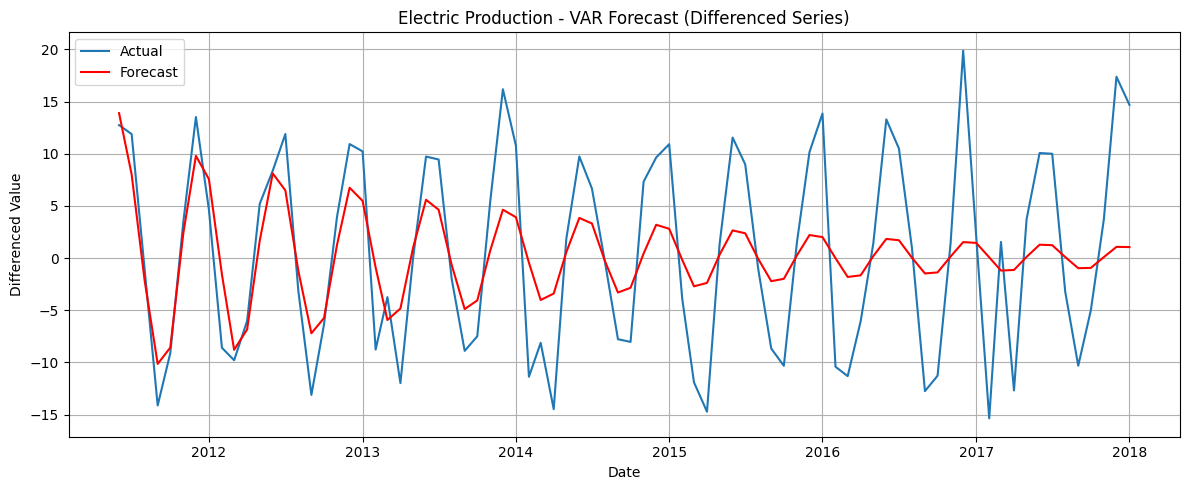

RMSE: 7.0245


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Load dataset
df = pd.read_csv('/content/Electric_Production.csv', parse_dates=['DATE'])
df.set_index('DATE', inplace=True)

# Rename for easier access
df.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)

# Add dummy second variable (simulated temperature trend)
df['Dummy_Temp'] = df['Electric_Production'].rolling(window=3, min_periods=1).mean()

# Drop NA caused by rolling
df.dropna(inplace=True)

# ADF test function
def make_stationary(data):
    diffed = data.copy()
    for col in data.columns:
        result = adfuller(diffed[col])
        if result[1] > 0.05:
            print(f"{col} is non-stationary, differencing applied (p={result[1]:.4f})")
            diffed[col] = diffed[col].diff()
    return diffed.dropna()

# Make both series stationary
stationary_df = make_stationary(df)

# Split into train and test
n = int(len(stationary_df) * 0.8)
train = stationary_df[:n]
test = stationary_df[n:]

# Fit VAR model
model = VAR(train)
results = model.fit(maxlags=3, ic='aic')

# Forecast
lag_order = results.k_ar
forecast_input = train.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(test))

# Forecast DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Electric_Production_Pred', 'Dummy_Temp_Pred'])

# Plot results
plt.figure(figsize=(12,5))
plt.plot(test['Electric_Production'], label='Actual')
plt.plot(forecast_df['Electric_Production_Pred'], label='Forecast', color='red')
plt.title('Electric Production - VAR Forecast (Differenced Series)')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE Evaluation
rmse = np.sqrt(mean_squared_error(test['Electric_Production'], forecast_df['Electric_Production_Pred']))
print(f'RMSE: {rmse:.4f}')
